# Movie Data Pipeline Verification
This notebook verifies the outputs of the Ingestion, Transformation, KPI, and Visualization stages.

**Note:** Using Pandas for verification to avoid Hadoop/Windows configuration issues.

In [ ]:
import os
import pandas as pd
from IPython.display import Image, display

print("Libraries Imported")

## 1. Ingestion Verification (Bronze Layer)
Checking for raw data in `data/bronze/movies`.

In [ ]:
bronze_path_base = "../data/bronze/movies/"

if os.path.exists(bronze_path_base):
    # Find the latest ingestion partition
    partitions = sorted([d for d in os.listdir(bronze_path_base) if d.startswith("ingestion_date=")])
    if partitions:
        latest_partition = partitions[-1]
        full_path = os.path.join(bronze_path_base, latest_partition, "movies_raw.parquet")
        print(f"Reading from: {full_path}")
        
        try:
            # Read parquet directory using pandas
            df_bronze = pd.read_parquet(full_path)
            print(f"Row Count: {len(df_bronze)}")
            display(df_bronze.head(5))
        except Exception as e:
            print(f"Error reading parquet: {e}")
    else:
        print("No ingestion partitions found.")
else:
    print(f"Path not found: {bronze_path_base}")

## 2. Transformation Verification (Silver Layer)
Checking currated data in `data/silver/movies_curated`.

In [ ]:
silver_path = "../data/silver/movies_curated"

if os.path.exists(silver_path):
    print(f"Reading from: {silver_path}")
    try:
        df_silver = pd.read_parquet(silver_path)
        print(f"Row Count: {len(df_silver)}")
        print(f"Columns: {df_silver.columns.tolist()}")
        # Show key columns
        cols_to_show = [c for c in ["id", "title","release_date", "genres","belongs_to_collection","budget_musd", "revenue_musd", "roi"] if c in df_silver.columns]
        display(df_silver[cols_to_show].head(10))
    except Exception as e:
            print(f"Error reading silver data: {e}")
else:
    print(f"Path not found: {silver_path}")

## 3. KPI Verification (Gold Layer)
Checking aggregated KPIs in `data/gold`.
Call `get_kpi(name)` to see specific metrics.

In [25]:
gold_path = "../data/gold"

def get_kpi(kpi_name, n=5, show_index=False, col_name=None):
    """
    Fetches and displays a specific KPI.

    Args:
        kpi_name (str): Name of the KPI (e.g., 'highest_revenue')
        n (int): Number of rows to display
        show_index (bool): Whether to display the dataframe index
        col_name (str): If provided, returns the single value of this column for the top row.
    """
    # Column mapping for cleaner display
    columns_map = {
        "highest_revenue": ["title", "revenue_musd", "budget_musd", "profit_musd", "release_date"],
        "highest_roi": ["title", "roi", "revenue_musd", "budget_musd", "release_date"],
        "highest_profit": ["title", "profit_musd", "revenue_musd", "budget_musd"],
        "lowest_profit": ["title", "profit_musd", "revenue_musd", "budget_musd"],
        "most_popular": ["title", "popularity", "vote_average", "vote_count"],
        "highest_rated": ["title", "vote_average", "vote_count"],
        "lowest_rated": ["title", "vote_average", "vote_count"],
        "most_voted": ["title", "vote_count", "vote_average", "popularity"],
        "highest_budget": ["title", "budget_musd", "revenue_musd", "profit_musd"],
        "lowest_roi": ["title", "roi", "revenue_musd", "budget_musd"],
    }

    kpi_path = os.path.join(gold_path, kpi_name)

    if os.path.exists(kpi_path):
        try:
            df = pd.read_parquet(kpi_path)

            # If getting a single value
            if col_name:
                if col_name in df.columns:
                     val = df.iloc[0][col_name]
                     print(f"{kpi_name} -> {col_name}: {val}")
                     return val
                else:
                    print(f"Column '{col_name}' not found in {kpi_name}")
                    return None

            # Filter columns if defined
            if kpi_name in columns_map:
                cols = [c for c in columns_map[kpi_name] if c in df.columns]
                df = df[cols]

            # Get top n rows
            df_display = df.head(n)

            print(f"--- {kpi_name} ---")
            if not show_index:
                print(df_display.to_string(index=False))
            else:
                 display(df_display)

        except Exception as e:
            print(f"Error reading {kpi_name}: {e}")
    else:
        print(f"KPI '{kpi_name}' not found at {kpi_path}")

print("Updated get_kpi. Use `get_kpi('highest_profit', col_name='profit_musd')` to get a single value.")

Updated get_kpi. Use `get_kpi('highest_profit', col_name='profit_musd')` to get a single value.


In [26]:
# Example 1: Highest Profit Value Only
top_profit = get_kpi("highest_profit", col_name="profit_musd")

highest_profit -> profit_musd: 2686.706026


In [29]:
# Example 2: Lowest Revenue (using lowest_roi or lowest_profit as example)
get_kpi("lowest_profit", col_name="profit_musd")

lowest_profit -> profit_musd: 1032.69883


np.float64(1032.69883)

In [34]:
get_kpi("most_popular", col_name="popularity")

most_popular -> popularity: 67.9234


np.float64(67.9234)

In [33]:
get_kpi("lowest_roi", col_name="roi")

lowest_roi -> roi: 4.442329433333334


np.float64(4.442329433333334)

## 4. Visualization Verification
Displaying generated images from `data/visualizations`.

Displaying: franchise_vs_standalone_mean_popularity.png


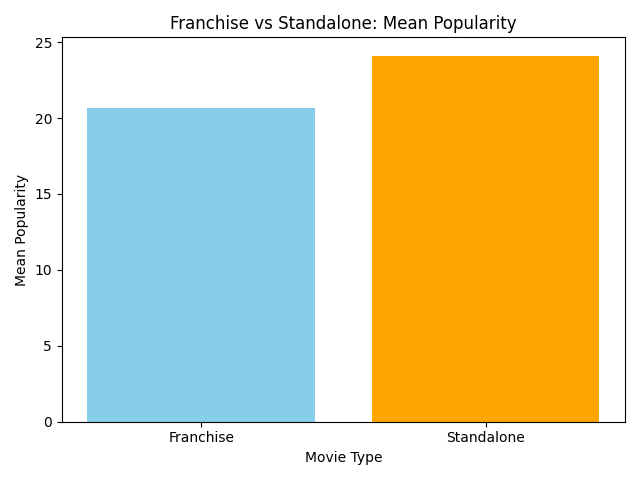

Displaying: franchise_vs_standalone_mean_rating.png


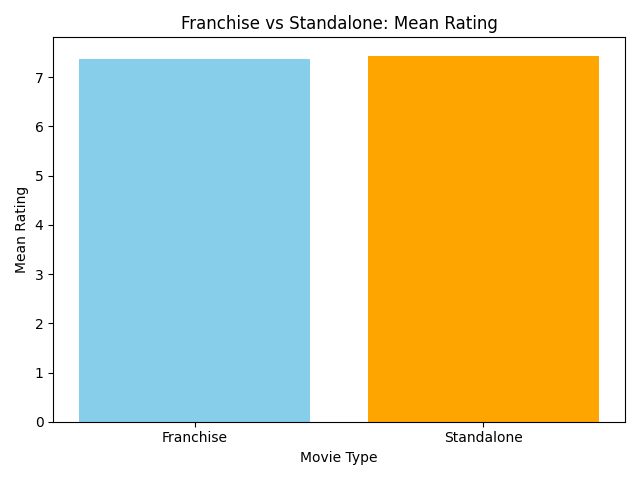

Displaying: franchise_vs_standalone_mean_revenue.png


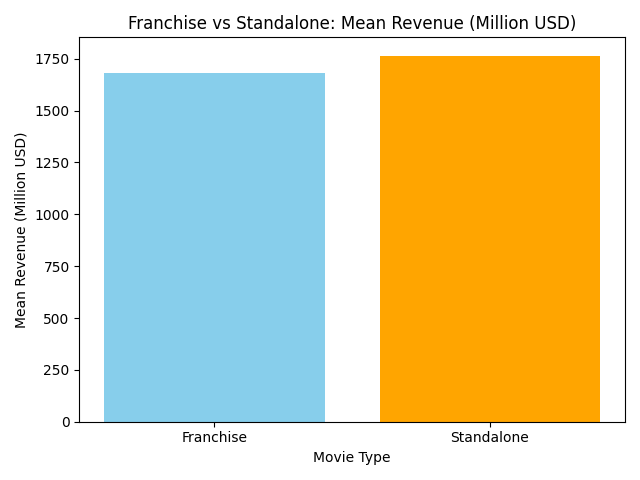

Displaying: popularity_vs_rating.png


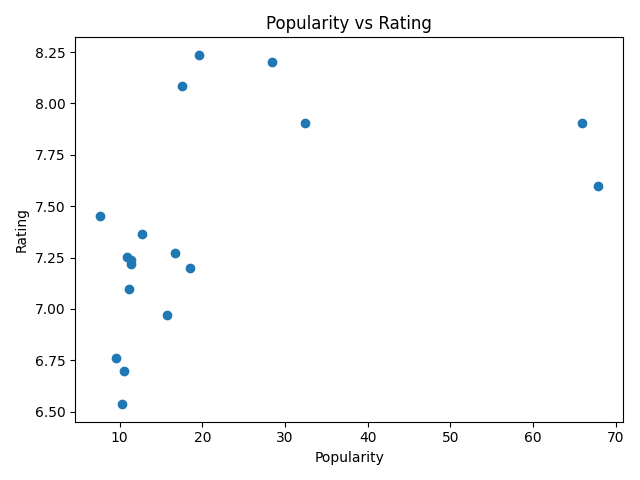

Displaying: revenue_vs_budget.png


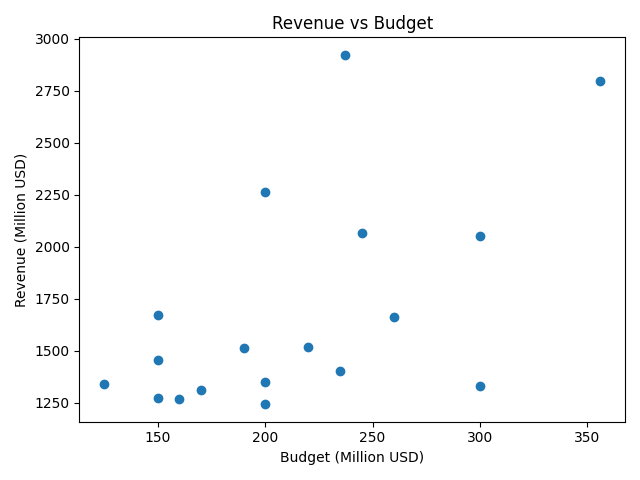

Displaying: roi_by_genre_bar.png


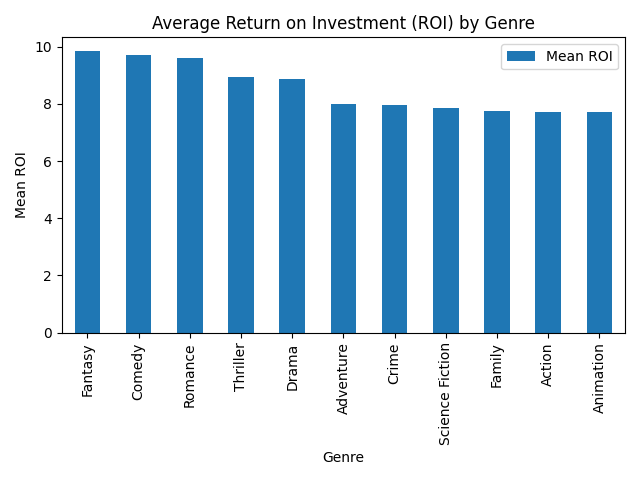

Displaying: yearly_trends.png


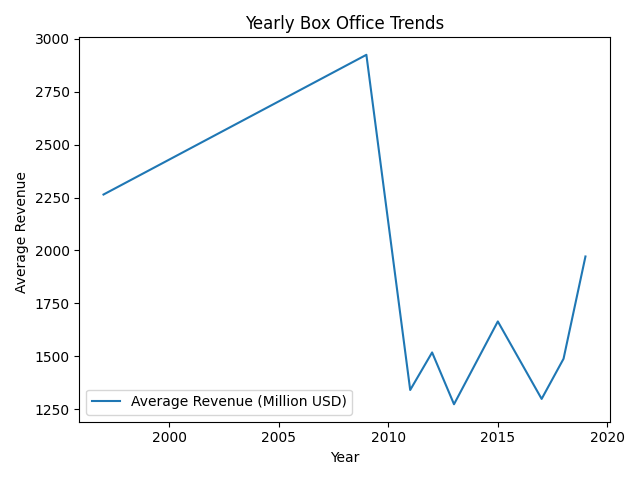

In [35]:
visual_path = "../data/visualizations"

if os.path.exists(visual_path):
    images = [f for f in os.listdir(visual_path) if f.endswith(".png")]
    if images:
        for img in images:
            print(f"Displaying: {img}")
            display(Image(filename=os.path.join(visual_path, img)))
    else:
        print("No .png images found in visualizations folder.")
else:
    print(f"Path not found: {visual_path}")